# Creating the dataset

In [9]:
import numpy as np
from collections import defaultdict
import pandas as pd

NUM_USERS = 10_000
NUM_ITEMS = 1_000
user_id = np.arange(start = 0, stop = NUM_USERS)
item_id = np.arange(start = 0, stop = NUM_ITEMS)
np.random.seed(42)
user_item_dict = defaultdict(list)
genres = ['Action','Comedy','Drama','Fantasy','Horror','Mystery','Romance','Thriller']

for id in user_id:
    #each user rates 3 to 5 items
    num_random_item = np.random.randint(low = 3, high = 5)
    
    rand_rating = np.random.randint(low=1, high=10, size=num_random_item)
    rand_items = np.random.choice(item_id, size = num_random_item, replace = False)
    
    for u_id, i_id, rating in zip([id] * num_random_item, rand_items, rand_rating):
        user_item_dict['user_id'].append(u_id)
        user_item_dict['item_id'].append(i_id)
        user_item_dict['rating'].append(rating)

ratings = pd.DataFrame(user_item_dict)
ratings[['user_id', 'item_id']] = ratings[['user_id', 'item_id']].astype(str)
print(ratings.head())

  user_id item_id  rating
0       0     938       4
1       0     630       8
2       0     682       5
3       1     464       8
4       1     542       2


In [10]:
item_genre_dict = defaultdict(list)
for id in item_id:
    #random no. of genres
    num_rand_genre = np.random.randint(low=1, high=3)
    rand_genres = np.random.choice(genres, size = num_rand_genre, replace = False)
    item_genre_dict['item_id'].append(id)
    item_genre_dict['genres'].append(' ,'.join(list(rand_genres)))
    
items = pd.DataFrame(item_genre_dict)
items = items.astype(str)
print(items.head())

  item_id           genres
0       0  Horror ,Romance
1       1          Fantasy
2       2            Drama
3       3   Drama ,Fantasy
4       4  Fantasy ,Horror


# Popular Based 

- Intuitive
- Most basic
- Usually used when user has no data yet
- All users get the same recommendation set. Not personalized.
- IMdB uses weighted rating formula for this

- FORMULA: WR = (v/(v+m))*R + (m/(v+m)) * C

- WR: Weighted Rating
- v: number of votes for the item
- m: minimum number of votes to be listed in the popular items (defined by > 80th percentile of all votes)
- R: average rating for an item
- C: average rating across the whole dataset


In [14]:
# Calculating the weighted training
def weighted_rating(v, m, R, C):
    return ((v/(v+m)) * R) + ((m/(v+m)) * C)

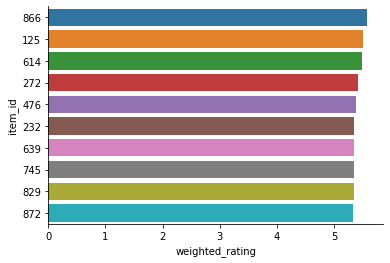

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def assign_popular_based_score(rating_df, item_df, user_col, item_col, rating_col):
    vote_count = (rating_df.groupby(item_col, as_index=False).agg({user_col:'count', rating_col: 'mean'}))
    vote_count.columns = [item_col, 'vote_count', 'avg_rating']
    
    C = np.mean(vote_count['avg_rating'])
    m = np.percentile(vote_count['vote_count'], 80)
    vote_count = vote_count[vote_count['vote_count'] > m]
    R = vote_count['avg_rating']
    v = vote_count['vote_count']
    vote_count['weighted_rating'] = weighted_rating(v, m, R, C)
    
    vote_count = vote_count.merge(item_df, on=[item_col], how='left')
    popular_items = vote_count.loc[:,[item_col, 'genres', 'vote_count', 'avg_rating', 'weighted_rating']]
    return popular_items

popular_items = assign_popular_based_score(ratings, items, 'user_id', 'item_id', 'rating')
popular_items = popular_items.sort_values('weighted_rating', ascending = False)

#plot based on popularity

fig, axis = plt.subplots()
sns.barplot(data = popular_items.head(10), y = 'item_id', x = 'weighted_rating')
sns.despine()

# Content Based

- Based on genres feature to find similar item
- one hot encoding of the genre column
- find the similarity b/w each item

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

def top_k_items(item_id, top_k, corr_mat, map_name):
    #get all cosine_similarities for this item id with others, sort it, get last top k, reverse it
    top_items = corr_mat[item_id, :].argsort()[-top_k:][::-1]
    top_items = [map_name[e] for e in top_items]
    return top_items

#getting all items that are rated
rated_items = items.loc[items['item_id'].isin(ratings['item_id'])].copy()

#genre = list of genres column split by ",": it becomes a series where each row is a list
genre = rated_items['genres'].str.split(",", expand = True)

# generate distinct genres
all_genre = set()
for c in genre.columns:
    distinct_genre = genre[c].str.lower().str.strip().copy()
    all_genre.update(distinct_genre)
all_genre.remove(None)

# generate matrix w item_id and genre
item_genre_mat = rated_items[['item_id', 'genres']].copy()
item_genre_mat['genres'] = item_genre_mat['genres'].str.lower().str.strip()

# one hot encoding of genres. result is a matrix where index is item_id and rows are what genres they belong to
for genre in all_genre:
    item_genre_mat[genre] = np.where(item_genre_mat['genres'].str.contains(genre), 1, 0)
item_genre_mat = item_genre_mat.drop(['genres'], axis = 1)
item_genre_mat = item_genre_mat.set_index('item_id')

#compute similarity matrix
corr_mat = cosine_similarity(item_genre_mat)

# dict with index to name
index_to_name = {ind:name for ind, name in enumerate(item_genre_mat.index)}
name_to_index = {v:k for k,v in index_to_name.items()}

#getting 10 similar movies to movie no. 86
similar_movies = top_k_items(name_to_index['86'], top_k = 10, corr_mat = corr_mat, map_name = index_to_name)

print("top 10 similar movie to item_id 86: ")
print(items.loc[items['item_id'].isin(similar_movies)])

#the movie 86 itself is also listed

top 10 similar movie to item_id 86: 
    item_id          genres
46       46  Fantasy ,Drama
86       86  Drama ,Fantasy
129     129  Fantasy ,Drama
405     405  Fantasy ,Drama
519     519  Fantasy ,Drama
657     657  Fantasy ,Drama
673     673  Fantasy ,Drama
789     789  Fantasy ,Drama
810     810  Drama ,Fantasy
812     812  Fantasy ,Drama


# Collaborative Filtering

### 2 Main approaches
1. Memory Based
2. Model Based

- User Based Implementation:
    1. Find group of similar users based on similarity metric of your choice
    2. Average the rating of each item based on the group of similar users
    3. Rank the item based on the descending average rating, and recommend the target user with the item they have not interacted with before
    - Recommendation is personalized for each user
    - Limitation: cold-start problem: we need prior information about the user to derive the simlarity for this user and others. Fix: provide the new user with popular-based recommendations first.
    
- Item Based Implementation
    1. Find group of similar items based on similrity metric of your choice
    2. Select up to the top k most similar items to recommend
    - similar to popular based/content based filtering
    - difference is that the user-item matrix is used to rather than rating on genres like above methods implemented
    - Limitation: same as user based implementation

## Memory Based

- calculates similarity directly matrix from user-item matrix
- Similarity Metrics:
    1. Pearson Correlation
    2. Cosine similarity
    3. Others



- Limitation: it is memory-based i.e. the interaction between user and item is memorized and retrieve results based on that. Can pose a problem w scalability. In reality, the imabalanc between no. of users and items makes the user-item matrix very sparse - leading to poor generalization of the predicted result.





In [39]:
from scipy.sparse import csr_matrix

row = ratings['user_id']
col = ratings['item_id']
data = ratings['rating']

mat = csr_matrix((data, (row, col)), shape = (NUM_USERS, NUM_ITEMS))
mat.eliminate_zeros()

# calculate sprasity matrix
print(len(mat.nonzero()[0]))

35002


### Better approach

- Instead of computation with the user-item interaction matrix, decompose this matrix into user and item latent factor matrix using matrix factorization. 
- The idea is that observed user-item matrix is constructed from underlying user and item latent factor matrices
- Goal is to minimize loss between the reconstructed matrix and the original matrix
- Then the inner product of the user and item latent factor matrix can be used for inferencing an unobserved rating
- ML comes into play during matrix factorization


### Model Based approach

- solves scalability issue
- 3 techniques used here:
    1. Truncated SVD:
        - sklearn library
        - variant of singular value decomposition that calculates only the k-largest singular values
        - applies linear dimensionality reduction 
        - works well w sparse matrix
        - users matrix: N X k matrices
        - items matrix: M X k matr|ices
        - Disadv: The scalability is still a problem for this algorithm, even if we reduce the size of a matrix with the decomposition method. 
        - Disadv: the explainability would be a problem too. We don't know how to describe each latent factor in terms of human interpretation.

In [45]:
from sklearn.decomposition import TruncatedSVD

# initial hyperparameter
epsilon = 1e-9
n_latent_factors = 10

# generate item lantent features
item_svd = TruncatedSVD(n_components = n_latent_factors)
item_features = item_svd.fit_transform(mat.transpose()) + epsilon

# generate user latent features
user_svd = TruncatedSVD(n_components = n_latent_factors)
user_features = user_svd.fit_transform(mat) + epsilon

item_corr_mat = cosine_similarity(item_features)

# get top k item
similar_items = top_k_items(name_to_index['86'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = index_to_name)
print(items.loc[items['item_id'].isin(similar_items)])

    item_id            genres
18       18            Horror
72       72             Drama
86       86    Drama ,Fantasy
171     171    Action ,Horror
188     188   Mystery ,Action
664     664           Mystery
743     743            Comedy
835     835   Fantasy ,Comedy
916     916  Fantasy ,Mystery
976     976    Drama ,Romance


    2. Funk Matrix Factorization:
        - objective of FunkFM is to estimate the latent factor matrix and the bias termed minimizing the loss between the original explicit rating and the reconstructed prediction rating. Therefore, this kind of approach is model-based.
        - this model only takes into account the explicit rating and it doesn't care about the implicit rating
        
        

In [60]:
from surprise import SVD, accuracy
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection.split import train_test_split

def pred2dict(predictions, top_k=None):
    
    rec_dict = defaultdict(list)
    for user_id, item_id, actual_rating, pred_rating, _ in predictions:
        rec_dict[user_id].append((item_id, pred_rating))        
        
    return rec_dict

def get_top_k_recommendation(rec_dict, user_id, top_k, ind2name):
    
    pred_ratings = rec_dict[user_id]
    # sort descendingly by pred_rating
    pred_ratings = sorted(pred_ratings, key=lambda x: x[1], reverse=True)
    pred_ratings = pred_ratings[:top_k]
    recs = [ind2name[e[0]] for e in pred_ratings]
    
    return recs

# prepare train and test sets
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(ratings, reader)
train, test = train_test_split(data, test_size=.2, random_state=42)

# init and fit the funk mf model
algo = SVD(random_state = 42)
algo.fit(train)
pred = algo.test(test);

# evaluation the test set
accuracy.rmse(pred)

# extract the item features from algo
item_corr_mat = cosine_similarity(algo.qi)


similar_items = top_k_items(name_to_index['86'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = index_to_name)

print(items.loc[items['item_id'].isin(similar_items)])

RMSE: 2.6446
    item_id           genres
60       60          Fantasy
86       86   Drama ,Fantasy
180     180   Romance ,Drama
542     542          Fantasy
570     570  Romance ,Horror
589     589   Horror ,Action
788     788    Drama ,Comedy
814     814           Comedy
818     818  Fantasy ,Comedy
985     985          Romance


        3. Generalized Matrix Factorization (GMF) (Keras)
            - Idea: the embedding layers that dense the sparse input user and item vector (user-item interaction matrix) can be seen as a latent factor matrix in the normal matrix factorization process.
            

In [61]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split

def df_to_ds(df):
    return {
        "user_id" : tf.constant(df['user_id'].tolist()),
        "item_id" : tf.constant(df['item_id'].tolist()),
        'rating' : tf.constant(df['rating'].tolist())
    }

class RankingModel(keras.Model):

    def __init__(self, user_id, item_id, embedding_size):
        super().__init__()
        
        # user model
        input = keras.Input(shape=(), dtype=tf.string)
        x = keras.layers.StringLookup(
            vocabulary = user_id, mask_token = None
            )(input)
        output = keras.layers.Embedding(
            input_dim = len(user_id) + 1,
            output_dim = embedding_size,
            name = 'embedding'
        )(x)
        self.user_model = keras.Model(inputs = input,
                                      outputs = output,
                                      name = 'user_model')

        # item model
        input = keras.Input(shape=(), dtype=tf.string)
        x = keras.layers.StringLookup(
            vocabulary = item_id, mask_token = None
            )(input)
        output = keras.layers.Embedding(
            input_dim = len(item_id) + 1,
            output_dim = embedding_size,
            name = 'embedding'
        )(x)
        self.item_model = keras.Model(inputs = input,
                                  outputs = output,
                                  name = 'item_model')

        # rating model
        concat_shape = self.user_model.layers[-1].output_shape[1] \
        + self.item_model.layers[-1].output_shape[1] 

        input = keras.Input(shape=(concat_shape,))
        x = keras.layers.Dense(256, activation = 'relu')(input)
        x = keras.layers.Dense(64, activation = 'relu')(x)
        output = keras.layers.Dense(1)(x)
        
        self.ratings = keras.Model(
            inputs = input,
            outputs = output,
            name = 'rating_model'
        )

    def call(self, inputs):

        user_id, item_id = inputs

        user_emb = self.user_model(user_id)
        item_emb = self.item_model(item_id)
        concat = tf.concat([user_emb, item_emb], axis = 1)
        prediction = self.ratings(concat)
        
        return prediction

class GMFModel(tfrs.models.Model):

    def __init__(self, user_id, item_id, embedding_size):
        super().__init__()
        self.ranking_model = RankingModel(user_id,
                                          item_id,
                                          embedding_size)
        self.task = tfrs.tasks.Ranking(
            loss = keras.losses.MeanSquaredError(),
            metrics = [keras.metrics.RootMeanSquaredError()]
        )
    
    def call(self, features):
        return self.ranking_model(
            (features[0]['user_id'], features[0]['item_id'])
        )

    def compute_loss(self, features, training=False):
        label = features[0]['rating']
        return self.task(labels = label,
                         predictions = self(features))


# preprocess
train, test = train_test_split(ratings, train_size = .8, random_state=42)
train, test = df_to_ds(train), df_to_ds(test)

# init model
embedding_size = 32
model = GMFModel(user_id.astype(str), item_id.astype(str), embedding_size)
model.compile(
    optimizer = keras.optimizers.Adagrad(learning_rate = .01)
)

# fitting the model
model.fit(train, epochs=3, verbose=0)

# evaluate with the test data
result = model.evaluate(test, return_dict=True, verbose=0)
print("\nEvaluation on the test set:")
display(result)

# extract item embedding
item_emb = model.ranking_model.item_model.layers[-1].get_weights()[0]


item_corr_mat = cosine_similarity(item_emb)

similar_items = top_k_items(name_to_index['86'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = index_to_name)

print(items.loc[items['item_id'].isin(similar_items)])




Evaluation on the test set:


{'root_mean_squared_error': 2.749397039413452,
 'loss': 4.362840175628662,
 'regularization_loss': 0,
 'total_loss': 4.362840175628662}

    item_id             genres
25       25   Thriller ,Action
47       47            Mystery
86       86     Drama ,Fantasy
297     297  Fantasy ,Thriller
376     376             Action
409     409             Action
460     460           Thriller
713     713    Thriller ,Drama
915     915    Fantasy ,Action
928     928             Comedy
